In [88]:
#Modules nécessaires à l'étude, les modules indispensables sont réunis dans le fichier requirements.txt

import sklearn.preprocessing as prepro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture, metrics, cluster
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [89]:
# Ouverture du ficher
data = pd.read_csv("../src/data.csv")

colnames = data.columns
print(data.columns)
print("\n##################################\n")
# Permet d'afficher les types de colonnes
print(data.dtypes) 


Index(['country', 'child_mortality', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expectation', 'total_fertility', 'GDP'],
      dtype='object')

##################################

country              object
child_mortality     float64
exports             float64
health              float64
imports             float64
income                int64
inflation           float64
life_expectation    float64
total_fertility     float64
GDP                 float64
dtype: object


In [90]:
# Calcul du nombre de données manquantes par variable
print(pd.isna(data).sum()) 

country             0
child_mortality     0
exports             0
health              0
imports             0
income              0
inflation           0
life_expectation    0
total_fertility     2
GDP                 2
dtype: int64


In [91]:
print(data.head())

               country  child_mortality  exports  health  imports  income  \
0          Afghanistan             90.2     10.0    7.58     44.9    1610   
1              Albania             16.6     28.0    6.55     48.6    9930   
2              Algeria             27.3     38.4    4.17     31.4   12900   
3               Angola            119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda             10.3     45.5    6.03     58.9   19100   

   inflation  life_expectation  total_fertility      GDP  
0       9.44              56.2             5.82    553.0  
1       4.49              76.3             1.65   4090.0  
2      16.10              76.5             2.89   4460.0  
3      22.40              60.1             6.16   3530.0  
4       1.44              76.8             2.13  12200.0  


In [92]:
# Remplace les valeurs vides par la moyenne globale de cette variable
data_1 = data.fillna(data.mean()) 
print(pd.isna(data_1).sum())

country             0
child_mortality     0
exports             0
health              0
imports             0
income              0
inflation           0
life_expectation    0
total_fertility     0
GDP                 0
dtype: int64


In [93]:
# Affichage des statistiques basiques sur les données
print(data_1.describe()) 

       child_mortality     exports      health     imports         income  \
count       167.000000  167.000000  167.000000  167.000000     167.000000   
mean         38.270060   41.108976    6.815689   46.890215   17144.688623   
std          40.328931   27.412010    2.746837   24.209589   19278.067698   
min           2.600000    0.109000    1.810000    0.065900     609.000000   
25%           8.250000   23.800000    4.920000   30.200000    3355.000000   
50%          19.300000   35.000000    6.320000   43.300000    9960.000000   
75%          62.100000   51.350000    8.600000   58.750000   22800.000000   
max         208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expectation  total_fertility             GDP  
count  167.000000        167.000000        167.00000      167.000000  
mean     7.781832         70.134132          2.92600    29710.387879  
std     10.570704         10.435428          1.47034   132688.767896  
min     -4.210000     

In [94]:
# Suppression de la collone des pays pour le traitement
data_2 = data_1.drop(['country'], axis = 1) 

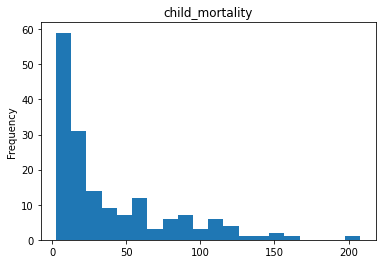

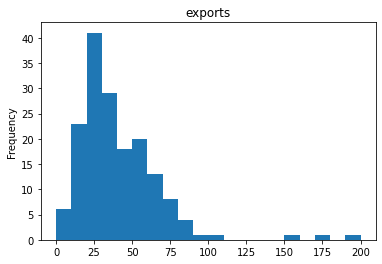

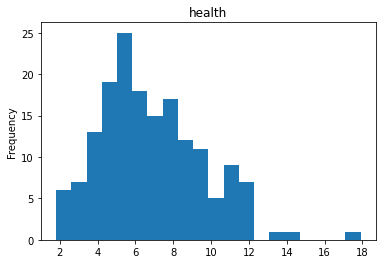

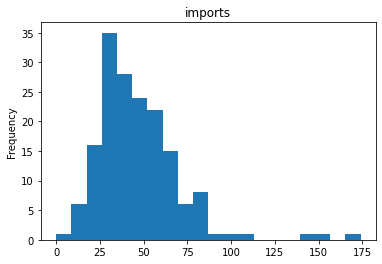

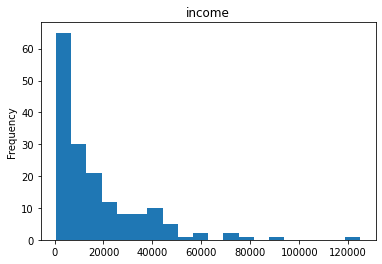

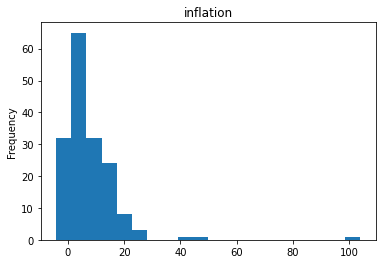

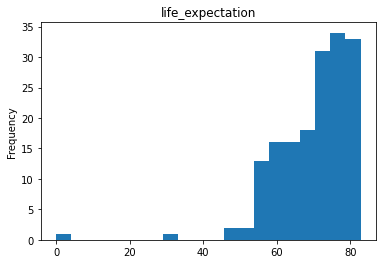

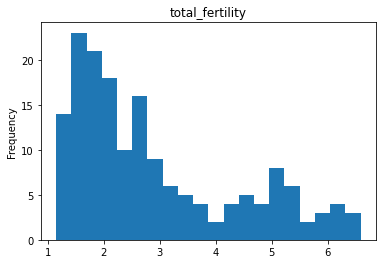

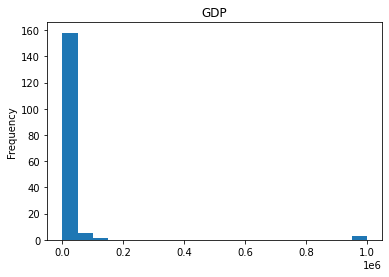

In [95]:
# Tracé des histogrammes de fréquence des différentes variables avant suppression des données aberrantes
for column in data_2.columns:
    data_2[column].iloc[:].plot.hist(bins = 20, subplots = True) 
    plt.title(column)
    plt.show()

# On conclut d'après ces histogrammes que certaines valeurs sont aberrantes et doivent être remplacées par la moyenne de la colonne

In [96]:
# Choix des quantiles de valeurs pour définir la plage des valeurs aberrantes
quantile_min = 0.15
quantile_max = 0.85

data_3 = pd.DataFrame()

for column in data_2.columns:

    mean = data_2[column].mean()
    q_min = data_2[column].quantile(quantile_min)
    q_max = data_2[column].quantile(quantile_max)

    for j in range(len(data_2[column].iloc[:])):
        if data_2[column].iloc[j] < q_min or data_2[column].iloc[j] > q_max :
            data_2[column][j] = mean
    
    data_3[column] = data_2[column]

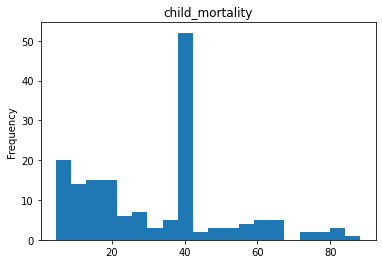

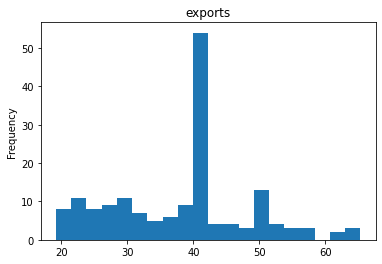

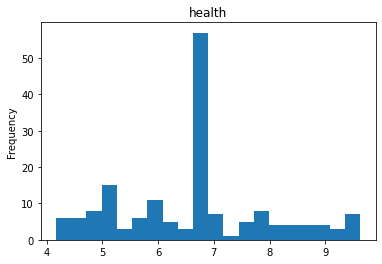

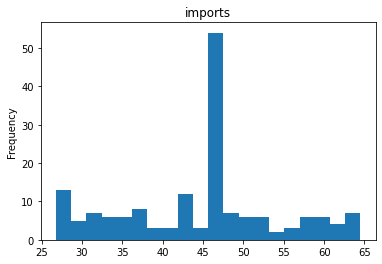

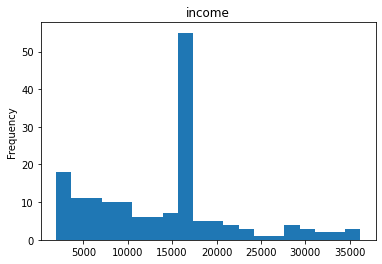

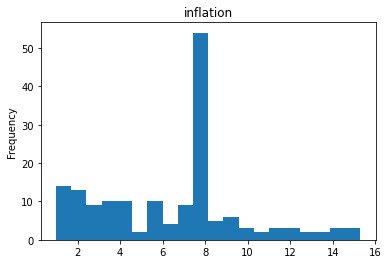

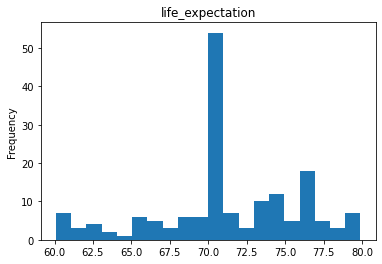

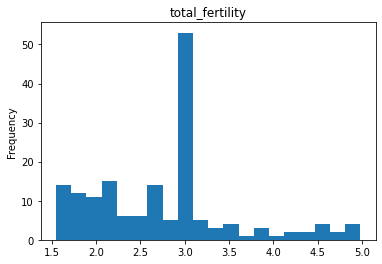

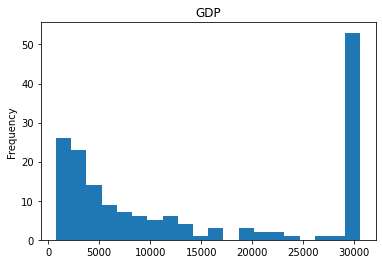

In [97]:
# Après suppression des valeurs aberrantes, on constate que la répartition des données est meilleure qu'avant
for column in data_3.columns:
    data_3[column].iloc[:].plot.hist(bins = 20, subplots = True)
    plt.title(column)
    plt.show()

In [98]:
# On centre et on réduit les données pour avoir des meilleures performances durant le clustering
scaler = prepro.StandardScaler()
scaler.fit(data_3)
data_4 = pd.DataFrame(scaler.transform(data_3))

print(data_4.describe())
# On constate que les moyennes des variables sont suffisamment faibles pour être considérées comme nulles

                  0             1             2             3             4  \
count  1.670000e+02  1.670000e+02  1.670000e+02  1.670000e+02  1.670000e+02   
mean   4.786590e-17 -3.377205e-16  8.848544e-16 -3.510166e-16  6.382120e-17   
std    1.003008e+00  1.003008e+00  1.003008e+00  1.003008e+00  1.003008e+00   
min   -1.403908e+00 -1.841701e+00 -1.890206e+00 -1.863193e+00 -1.531230e+00   
25%   -8.533663e-01 -8.384336e-01 -7.490699e-01 -7.765511e-01 -8.570173e-01   
50%    2.711999e-01  2.718147e-01  1.225209e-01  2.159372e-01  2.895814e-01   
75%    3.426951e-01  2.718147e-01  2.893637e-01  4.498016e-01  3.700620e-01   
max    2.948241e+00  2.605475e+00  2.263529e+00  2.038368e+00  2.751488e+00   

                  5             6             7             8  
count  1.670000e+02  1.670000e+02  1.670000e+02  1.670000e+02  
mean  -2.632625e-16  1.760069e-16  3.191060e-16 -9.839102e-17  
std    1.003008e+00  1.003008e+00  1.003008e+00  1.003008e+00  
min   -1.632672e+00 -2.373818e+0

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>,
        <AxesSubplot:xlabel='4', ylabel='0'>,
        <AxesSubplot:xlabel='5', ylabel='0'>,
        <AxesSubplot:xlabel='6', ylabel='0'>,
        <AxesSubplot:xlabel='7', ylabel='0'>,
        <AxesSubplot:xlabel='8', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>,
        <AxesSubplot:xlabel='4', ylabel='1'>,
        <AxesSubplot:xlabel='5', ylabel='1'>,
        <AxesSubplot:xlabel='6', ylabel='1'>,
        <AxesSubplot:xlabel='7', ylabel='1'>,
        <AxesSubplot:xlabel='8', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3',

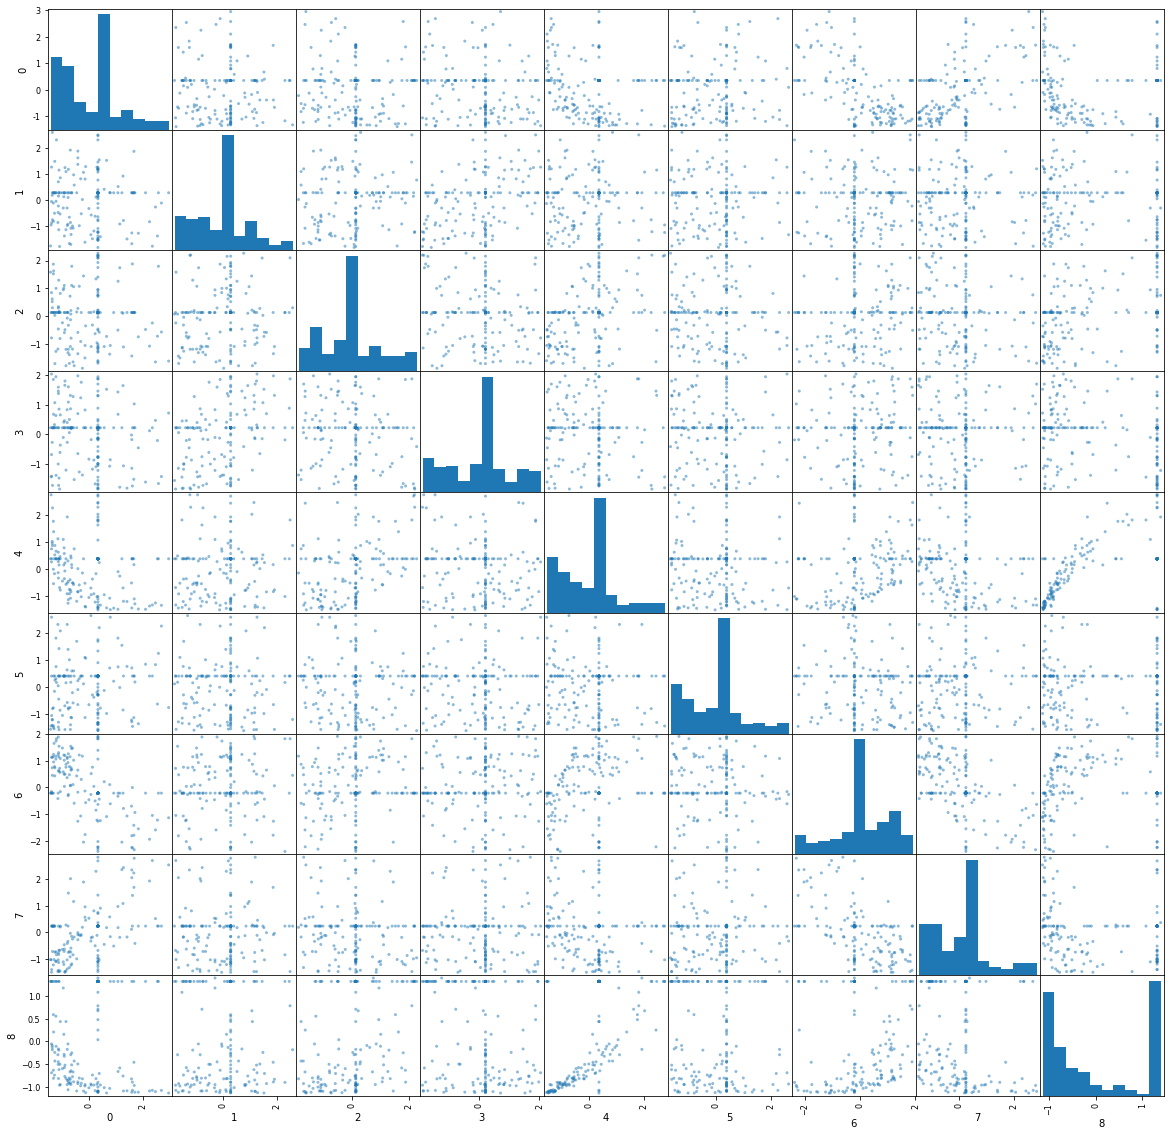

In [99]:
# Affichage des varaibles les unes en fonctions des autres pour voir les corrélations
pd.plotting.scatter_matrix(data_4, figsize = [20, 20])

# On peut maintenant observer les corrélations entre les variables GDP et income, et entre child_mortality et life_expectation

In [100]:
# On calcule les coefficient de corrélations des variables
data_4.corr()
# On observe une forte corrélation positive entre GDP et income et une corrélation négative entre child_mortality et life_expectation
# Ces observations semblent logiques d'un point de vue qualitatif et confirme les observations sur les graphes ci-dessus

,0,1,2,3,4,5,6,7,8
0,1.000000,-0.061397,-0.069315,-0.191009,-0.248345,0.104736,-0.606409,0.541121,0.038064
1,-0.061397,1.000000,0.107143,0.391109,0.058501,0.001585,0.042149,-0.001769,0.020294
2,-0.069315,0.107143,1.000000,-0.139634,0.391060,-0.054987,0.155945,-0.137676,0.344848
3,-0.191009,0.391109,-0.139634,1.000000,-0.101785,-0.085137,0.081279,-0.010623,-0.210046
4,-0.248345,0.058501,0.391060,-0.101785,1.000000,-0.092469,0.256210,-0.222210,0.602408
5,0.104736,0.001585,-0.054987,-0.085137,-0.092469,1.000000,-0.070546,0.014419,-0.014247
6,-0.606409,0.042149,0.155945,0.081279,0.256210,-0.070546,1.000000,-0.569168,0.065346
7,0.541121,-0.001769,-0.137676,-0.010623,-0.222210,0.014419,-0.569168,1.000000,-0.133685
8,0.038064,0.020294,0.344848,-0.210046,0.602408,-0.014247,0.065346,-0.133685,1.000000


In [101]:
##############################################################################################
# La phase de traitement est passée, nous abordons maintenant la partie clustering en commençant par définir les fonctions nécessaires au clustering.
# On retrouve les quatre fonctions de clustering, une fonction permettant d'obtenir le nom des pays dans chaque cluster et enfin les
# fonctions nécessaires à l'ACP

In [102]:
# Fonction permettant d'effectuer le clustering avec la méthode DBSCAN.

def dbscan(X_train, eps, min_samples):

    clustering = cluster.DBSCAN(eps = eps, min_samples = min_samples).fit(X_train)
    labels = clustering.labels_

    return labels

In [103]:
# Fonction permettant d'effectuer un clustering avec la méthode du mélange de gaussienne.

def gmm(X_train, nb_clusters):

    gmm = mixture.GaussianMixture(n_components = nb_clusters).fit(X_train)
    labels = gmm.predict(X_train)

    return labels

In [104]:
# Fonction permettant d'effectuer le clustering avec la méthode des k-means

def kmeans(X_train, nb_clusters, init, n_init):
    
    kmeans = cluster.KMeans(nb_clusters, init, n_init).fit(X_train)
    kmeans.predict(X_train)
    reskmeans = kmeans.transform(X_train)
    labels = kmeans.labels_

    return labels

In [105]:
# Fonction permettant d'effectuer le clustering avec la méthode du CHA

def hierarchique(X_train, method, metric, nb_clusters_max):

    l = linkage(X_train, method, metric)
    labels = fcluster(l, criterion = 'maxclust', t = nb_clusters_max)

    return labels

In [106]:
# Fonction permettant de faire la correspondance entre la liste des labels en sortie de fonctions de clustering et la liste de pays
# afin de récupérer la liste de pays de chaque cluster

def cluster_country(labels, countries):

    L_cluster = []
    for i in range(len(labels)):
        if labels[i] not in L_cluster:
            L_cluster.append(labels[i])

    L_country = []
    for i in range(len(L_cluster)):
        L_tmp = []
        for j in range(len(labels)):
            if labels[j] == L_cluster[i] :
                L_tmp.append(countries[j])

        L_country.append(L_tmp)

    return L_country

parts des variances pour chaque composantes : 
[27.8, 19.72, 14.55, 11.11, 7.95, 5.99, 5.19, 4.34, 3.35]

somme des parts de variance : 
[27.8, 47.52, 62.07, 73.18, 81.13, 87.12, 92.31, 96.65, 100.0]



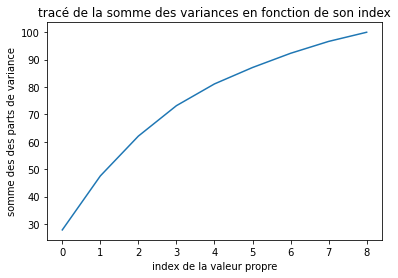


valeurs des valeurs propres : 
[20.44, 17.21, 14.79, 12.92, 10.93, 9.49, 8.83, 8.08, 7.1]



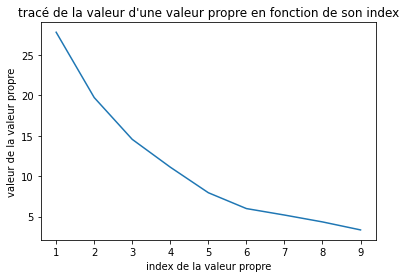

In [107]:
# Fonction calculant les parts des variances des différents axes et traçant le graphe des éboulis pour estimer le nombre de composantes à garder

def estiACP(data): 

    acp = PCA(svd_solver='full')
    acp.fit(data)

    varexpli = [round(var*100, 2) for var in acp.explained_variance_ratio_]
    print("parts des variances pour chaque composantes : \n"+str(varexpli)+"\n")

    sum_var = [round(sum(varexpli[:i+1]), 2) for i in range(len(varexpli))]
    print("somme des parts de variance : \n"+str(sum_var)+"\n")
    plt.plot([i for i in range(len(varexpli))], sum_var)
    plt.xlabel("index de la valeur propre")
    plt.ylabel("somme des des parts de variance")
    plt.title("tracé de la somme des variances en fonction de son index")
    plt.show()

    val = [round(vp, 2) for vp in acp.singular_values_]
    print("\nvaleurs des valeurs propres : \n"+str(val)+"\n")

    l=[i for i in range(1,len(varexpli)+1)]
    plt.plot(l,varexpli)
    plt.xlabel("index de la valeur propre")
    plt.ylabel("valeur de la valeur propre")
    plt.title("tracé de la valeur d'une valeur propre en fonction de son index")
    plt.show()

estiACP(data_4)

# On observe que les 5 premières composantes expliquent 70% de l'inertie totale.
# Afin de choisir le nombre de composantes que l'on garde, on calcule la moyenne des parts d'inertie qui vaut environ 11%
# et on garde autant de composantes qu'il a de part de variances au-dessu de cette moyenne de 11. On garde donc 4 composantes.
# Ces composantes quatre composantes sont également identifiables grâce à la recherche du point d'inflexion sur le graphe 
# représentant les valeurs propres en fonction de leur index.

In [108]:
#Prend en entrée les données (9 dimensions) et applique l'ACP en conservant le nombre de composantes principales déclarées

def ACP(data,nb_composantes_principales): 

    acp2=PCA(n_components = nb_composantes_principales)
    donnees_proj = acp2.fit_transform(data)
    return(donnees_proj)

In [109]:
# Liste des pays du fichier
countries = data['country'].to_numpy()

# Dataframe issu de l'ACP
data_proj = ACP(data_4, 4)


# Paramètre à configurer pour les algorithmes de clustering :

# Nombre de clusters pour les méthode du mélange des Gaussiennes et du k-means.
nb_clusters = 3
# Distance pour la méthode DBSCAN.
eps = 1
# Nombre minimum de voisins pour la méthode DBSCAN.
min_samples = 2
# Méthode de calcul du k-means.
init = "k-means++"
# Nombre de clusters à l'initialisation.
n_init = 2
# Metrique utilisée
metric = "euclidean"
#Methode utilisée parle le CHA
method = "complete"


# Liste des algorithmes que l'on peut lancer, il suffit de décommenter l'une des 8 lignes et d'éxécuter la cellule après.
# Les cellules d'après (jusquà la fin) dépendent toutes du choix de la méthode de clustering.

# Ces quatres lignes lancent les algorithmes avec les données issues de l'ACP
#labels = dbscan(data_proj, eps, min_samples)
#labels = gmm(data_proj, nb_clusters)
#labels = hierarchique(data_proj, method, metric, nb_clusters)
#labels = kmeans(data_proj, nb_clusters, init, n_init)

# Ces quatres lignes lancent les algorithmes avec les données traitées mais sans ACP
#labels = dbscan(data_4, eps, min_samples)
labels = gmm(data_4, nb_clusters)
#labels = hierarchique(data_4, method, metric, nb_clusters)
#labels = kmeans(data_4, nb_clusters, init, n_init)


# Affichage des pays de chaque cluster
L_country = cluster_country(labels, countries)
for country in L_country:
    print("\nIl y a "+str(len(country))+" pays dans ce cluster\n")
    print(country)
    print("\n\n##################\n\n")


# Nous avons fait le choix de rechercher trois clusters de données dans les pays, une cluster pour les pays développés et pour les pays en voie de développement et un dernier pour les pays peu développés. 


Il y a 52 pays dans ce cluster

['Afghanistan', 'Australia', 'Austria', 'Bangladesh', 'Belgium', 'Benin', 'Brunei', 'Burkina Faso', 'Burundi', 'Canada', 'Central African Republic', 'Congo Dem. Rep.', 'Cyprus', 'Denmark', 'Eritrea', 'Finland', 'France', 'Gambia', 'Germany', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iceland', 'Ireland', 'Italy', 'Japan', 'Kuwait', 'Liberia', 'Luxembourg', 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Niger', 'Norway', 'Qatar', 'Rwanda', 'Sierra Leone', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'Tajikistan', 'Tanzania', 'Togo', 'Uganda', 'United Arab Emirates', 'United Kingdom', 'United States']


##################



Il y a 77 pays dans ce cluster

['Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Bulgaria', 'Cambodia', 'Cameroon', 'Cape Verde', 'Chad', 'Chile', 'China', 'Colombia', 'Costa Rica', "Cote

In [110]:
# Afin d'identifier quel cluster correspond à celui des pays développés, on calcule les moyennes des différentes variables pour chaque cluster et on choisit le cluster des pays les moins développés
# en prenant le cluster dont la moyenne de la variable qui nous intéresse est la plus faible.
# Nous avons choisit de nous baser sur le 'GDP', ainsi le cluster avec la valeur moyenne de 'GDP' la plus faible est considéré comme étant celui des pays les moins développés
data_1['cluster'] = labels

mean_cluster = data_1.groupby(by = ['cluster']).mean()
print(mean_cluster)

         child_mortality    exports    health    imports        income  \
cluster                                                                  
0              49.911538  39.263269  7.897115  44.832692  27147.173077   
1              28.477922  40.749351  6.264545  48.674026  11034.675325   
2              42.181579  44.363395  6.452632  46.091208  15837.894737   

         inflation  life_expectation  total_fertility           GDP  
cluster                                                              
0         5.572038         68.565385         3.317538  79538.995688  
1         8.376078         71.697403         2.518571   5510.428571  
2         9.601632         69.113158         3.215789  10560.631579  


In [111]:
# Cette valeur doit être remplacée par le numéro du cluster qui a été identifié comme étant celui des pays les moins développés dans la cellule précédente
cluster_n = 2
# Nombre de pays que l'on souhaite dans la liste finale
number=10
# Liste des colonnes sur lesquelles on souhaite travailler
columns = ['GDP', 'child_mortality']

# Cette partie affiche les dix pays qui sont considérés comme ayant les plus besoin d'aide en fonction des colonnes sélectionnées précédemment pour la méthode clustering définies précédemment.
country_to_help = {}
for column in columns : 
    country_to_help[column] = []

    print("\nPour la variable '"+column+"' les pays à aider sont :")

    if column == 'child_mortality' : 
        worst_column = data_1.loc[data_1['cluster'] == cluster_n][column].sort_values(ascending = False)[:number]
    else:
        worst_column = data_1.loc[data_1['cluster'] == cluster_n][column].sort_values()[:number]

    for country in worst_column:

        compteur = 0
        country_tmp = data_1.loc[data_1[column] == country]['country'].to_numpy()[compteur]
        while country_tmp in country_to_help[column] :
            compteur += 1
            country_tmp = data_1.loc[data_1[column] == country]['country'].to_numpy()[compteur]

        country_to_help[column].append(country_tmp)
        print(country_tmp, " : ", data_1.loc[data_1[column] == country][column].to_numpy()[0])


# Une fois le cluster des pays les moins développés identifié, nous choisissons différents critères (qui sont les colonnes avec lesquelles on souhaite travailler) en choisissant les dix pays présentant les valeurs les 
# plus faibles. On obtient donc une liste de nb_colonnes*10 pays pour nous aider à la prise de décision.


Pour la variable 'GDP' les pays à aider sont :
Comoros  :  769.0
Kenya  :  967.0
Myanmar  :  988.0
Senegal  :  1000.0
Lao  :  1140.0
Mauritania  :  1200.0
Solomon Islands  :  1290.0
Cameroon  :  1310.0
Ghana  :  1310.0
India  :  1350.0

Pour la variable 'child_mortality' les pays à aider sont :
Benin  :  111.0
Mauritania  :  97.4
Comoros  :  88.2
Zambia  :  83.1
Lao  :  78.9
Sudan  :  76.7
Ghana  :  74.7
Senegal  :  66.8
Myanmar  :  64.4
Congo Rep.  :  63.9


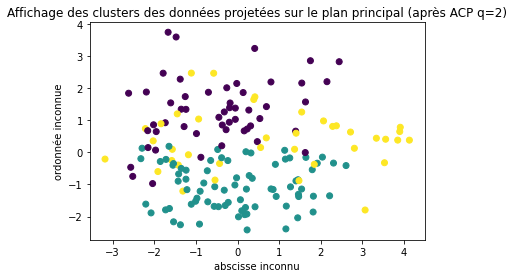

In [112]:
# Affichage des données après une ACP sur deux composantes afin de visualiser graphiquement le clustering.

data_proj_1 = ACP(data_4, 2)
plt.scatter(data_proj_1[:,0], data_proj_1[:,1], c = labels)
plt.title("Affichage des clusters des données projetées sur le plan principal (après ACP q=2)")
plt.xlabel("abscisse inconnu")
plt.ylabel("ordonnée inconnue")
plt.show()